# Évaluation du Pipeline : Détection et Identification
Ce notebook a pour but de quantifier les performances de notre système d'analyse de pièces de monnaie. 
L'évaluation se fait en 3 étapes strictes :
1. **Évaluation de la Détection :** Le système trouve-t-il les pièces (Précision, Rappel) ?
2. **Évaluation de l'Identification :** Quand une pièce est trouvée, son métal et sa valeur sont-ils corrects (Matrice de Confusion) ?
3. **Évaluation Globale (End-to-End) :** L'erreur finale sur la somme totale en euros par image.

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importation de nos modules
from coin_detector import CoinDetection
from coin_identification import CoinIdentification

# Configuration esthétique pour les graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Initialisation de nos classes
detector = CoinDetection(target_width=800)
# on désactive le KNN puisqu'il est optionnel et non utilisé dans la méthode finale
identifier = CoinIdentification(use_knn=False) 

IMAGE_DIR = './data/'

### 1. Chargement et Nettoyage de la Vérité Terrain
Nous chargeons le fichier CSV. Comme les valeurs en euros peuvent parfois être écrites avec des virgules (ex: "2,55" au lieu de "2.55"), nous nettoyons la colonne pour être sûrs d'avoir des chiffres précis.

In [64]:
# Chargement du fichier CSV
df_gt = pd.read_csv('ground_truth.csv')

# Nettoyage de la colonne 'value_eur' (remplacement des virgules, suppression des espaces, conversion en float)
df_gt['value_eur'] = df_gt['value_eur'].astype(str).str.replace(',', '.').str.replace('€', '').str.strip()

# Remplacement des valeurs vides éventuelles par 0 et conversion en décimal
df_gt['value_eur'] = pd.to_numeric(df_gt['value_eur'], errors='coerce').fillna(0.0)

# On retire les lignes où il y a 0 pièce (si applicable)
df_gt = df_gt[df_gt['num_coins'] > 0].reset_index(drop=True)

print(f"Vérité terrain chargée : {len(df_gt)} images à évaluer.")
display(df_gt.head())

Vérité terrain chargée : 106 images à évaluer.


,filename,num_coins,value_eur,group
0,18.png,7,4.31,gp1
1,19.png,4,1.60,gp1
2,20.png,8,4.81,gp1
3,21.png,6,3.76,gp1
4,22.png,5,2.25,gp1


### 2. Exécution du Pipeline sur l'ensemble du Dataset
Nous allons maintenant boucler sur toutes les images du CSV, lancer la Détection puis l'Identification, et stocker nos prédictions.
*(Cette étape peut prendre un peu de temps selon le nombre d'images).*

In [65]:
# Configuration esthétique pour les graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Chargement direct du fichier contenant déjà les prédictions !
df_res = pd.read_csv('results/detailed_results.csv')

print(f"Résultats chargés avec succès : {len(df_res)} images à évaluer.")
display(df_res.head())

Résultats chargés avec succès : 106 images à évaluer.


,group,filename,gt_count,pred_count,count_error,gt_value,pred_value,value_error,denominations_detected
0,gp1,18.png,7,7,0,4.31,3.63,0.68,"50c, 1euro, 1euro, 1euro, 10c, 2c, 1c"
1,gp1,19.png,4,4,0,1.60,1.75,0.15,"50c, 20c, 1euro, 5c"
2,gp1,20.png,8,8,0,4.81,3.65,1.16,"50c, 1euro, 1euro, 1euro, 10c, 2c, 2c, 1c"
3,gp1,21.png,6,6,0,3.76,1.93,1.83,"50c, 20c, 1euro, 20c, 2c, 1c"
4,gp1,22.png,5,5,0,2.25,3.20,0.95,"50c, 50c, 1euro, 20c, 1euro"


### 3. Métriques de Détection : Précision et Rappel (Comptage)
Puisque nous n'avons pas les coordonnées des pièces dans la vérité terrain, nous évaluons la détection sur le comptage :
* **Vrais Positifs (TP) :** Les pièces correctement trouvées (Min entre Prédites et Vraies).
* **Faux Positifs (FP) :** Les cercles hallucinés en trop.
* **Faux Négatifs (FN) :** Les pièces ratées par le détecteur.

In [66]:
# Calcul des statistiques au niveau du dataset global
total_true = df_res['gt_count'].sum()
total_pred = df_res['pred_count'].sum()

# Pour chaque image, TP = min(Vrai, Prédit)
TP = df_res.apply(lambda row: min(row['gt_count'], row['pred_count']), axis=1).sum()

# FP = Si on a prédit plus que la vérité (hallucinations)
FP = df_res.apply(lambda row: max(0, row['pred_count'] - row['gt_count']), axis=1).sum()

# FN = Si on a raté des pièces
FN = df_res.apply(lambda row: max(0, row['gt_count'] - row['pred_count']), axis=1).sum()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("--- PERFORMANCE DE DÉTECTION (COMPTAGE) ---")
print(f"Total des vraies pièces : {total_true}")
print(f"Total des pièces trouvées (TP) : {TP}")
print(f"Pièces manquées (Faux Négatifs) : {FN}")
print(f"Fausses alertes (Faux Positifs) : {FP}\n")
print(f"➤ PRÉCISION : {precision*100:.2f}% (Fiabilité de nos détections)")
print(f"➤ RAPPEL    : {recall*100:.2f}% (Capacité à ne rater aucune pièce)")
print(f"➤ F1-SCORE  : {f1_score*100:.2f}%")

--- PERFORMANCE DE DÉTECTION (COMPTAGE) ---
Total des vraies pièces : 1107
Total des pièces trouvées (TP) : 930
Pièces manquées (Faux Négatifs) : 177
Fausses alertes (Faux Positifs) : 24

➤ PRÉCISION : 97.48% (Fiabilité de nos détections)
➤ RAPPEL    : 84.01% (Capacité à ne rater aucune pièce)
➤ F1-SCORE  : 90.25%


### 4. Évaluation Financière (MAE : Erreur Absolue Moyenne)
Au-delà du nombre de pièces, notre but ultime est d'avoir la bonne somme en euros. 
Nous allons calculer la **MAE** : en moyenne, de combien de centimes notre algorithme se trompe-t-il par image ?
Nous allons également tracer un graphique de régression (Vraie Valeur VS Valeur Prédite).

Erreur Financière Moyenne (MAE) : 1.90 € par image


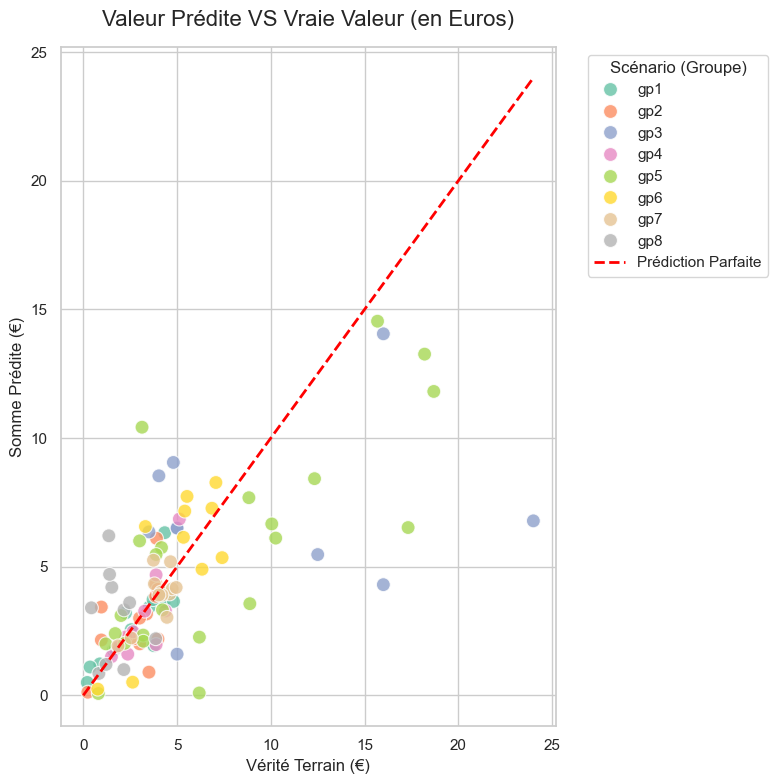

In [67]:
# La colonne 'value_error' existe déjà dans le CSV, on l'utilise directement
mae = df_res['value_error'].mean()
print(f"Erreur Financière Moyenne (MAE) : {mae:.2f} € par image")

# Graphique de Régression
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_res, x='gt_value', y='pred_value', hue='group', s=100, alpha=0.8, palette='Set2')

# Ligne rouge de prédiction parfaite (y = x)
max_val = max(df_res['gt_value'].max(), df_res['pred_value'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Prédiction Parfaite')

plt.title('Valeur Prédite VS Vraie Valeur (en Euros)', fontsize=16, pad=15)
plt.xlabel('Vérité Terrain (€)', fontsize=12)
plt.ylabel('Somme Prédite (€)', fontsize=12)
plt.legend(title='Scénario (Groupe)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 5. Analyse de Robustesse : Performances par Scénario (Group)
La vraie force d'un algorithme de traitement d'image n'est pas sa moyenne générale, mais sa robustesse face à la difficulté. 
Notre dataset est divisé en groupes (gp1, gp2, gp3...) représentant différents niveaux de complexité (fonds colorés, sombres, pièces collées). Observons où notre pipeline excelle et où il faiblit.

,group,MAE_Euros,Total_Images,Exactitude_Comptage_%
0,gp1,0.62,14,64.29
1,gp2,0.92,15,40.00
2,gp3,5.59,10,60.00
3,gp4,0.65,10,70.00
4,gp5,2.99,25,32.00
5,gp6,1.57,10,90.00
6,gp7,0.58,12,83.33
7,gp8,1.89,10,50.00


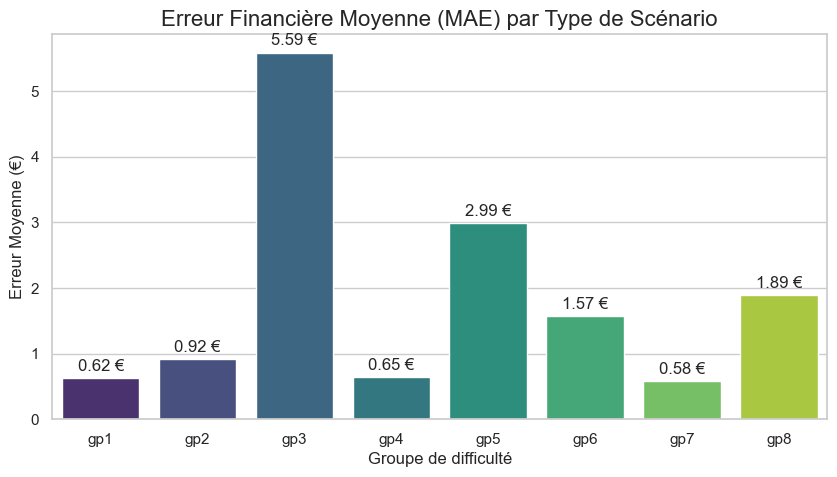

In [68]:
# On calcule aussi le pourcentage d'images où le comptage de pièces est 100% exact
df_res['count_perfect'] = (df_res['gt_count'] == df_res['pred_count']).astype(int)

# On agrège les stats par groupe
group_stats = df_res.groupby('group').agg(
    MAE_Euros=('value_error', 'mean'),
    Total_Images=('filename', 'count'),
    Exactitude_Comptage_pct=('count_perfect', lambda x: x.mean() * 100)
).reset_index()

# Renommer la colonne pour un plus bel affichage
group_stats.rename(columns={'Exactitude_Comptage_pct': 'Exactitude_Comptage_%'}, inplace=True)
display(group_stats.round(2))

# Graphique de l'Erreur MAE par Groupe
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=group_stats, x='group', y='MAE_Euros', palette='viridis')

# Ajout des valeurs sur les barres
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f €', padding=3)

plt.title('Erreur Financière Moyenne (MAE) par Type de Scénario', fontsize=16)
plt.xlabel('Groupe de difficulté', fontsize=12)
plt.ylabel('Erreur Moyenne (€)', fontsize=12)
plt.show()

In [69]:
total_images = len(df_res)

# 1. Exactitude du comptage (Détection)
exact_count_matches = df_res[df_res['gt_count'] == df_res['pred_count']].shape[0]
count_accuracy = (exact_count_matches / total_images) * 100

# 2. Exactitude financière 
# On utilise < 0.01 pour éviter les bugs d'arrondis des floats
exact_value_matches = df_res[abs(df_res['gt_value'] - df_res['pred_value']) < 0.01].shape[0]
value_accuracy = (exact_value_matches / total_images) * 100

# 3. Totaux financiers
total_true_eur = df_res['gt_value'].sum()
total_pred_eur = df_res['pred_value'].sum()

print("=========================================================")
print("                BILAN FINAL DU PROJET            ")
print("=========================================================")
print(f"Nombre total d'images évaluées : {total_images}\n")

print("--- 1. PERFORMANCE DE DÉTECTION (COMPTAGE) ---")
print(f"Total des pièces réelles : {df_res['gt_count'].sum()}")
print(f"Total des pièces vues    : {df_res['pred_count'].sum()}")
print(f"➤ EXACTITUDE COMPTAGE    : {count_accuracy:.2f} % (Images avec le compte parfait)")

print("\n--- 2. PERFORMANCE FINANCIÈRE (IDENTIFICATION) ---")
print(f"Somme totale réelle sur le dataset : {total_true_eur:.2f} €")
print(f"Somme totale calculée par l'algo   : {total_pred_eur:.2f} €")
print(f"Écart financier global absolu      : {abs(total_true_eur - total_pred_eur):.2f} €")
print(f"➤ EXACTITUDE FINANCIÈRE GLOBALE    : {value_accuracy:.2f} % (Images avec le total en euros PARFAIT)")

print("\n--- 3. TAUX D'ERREUR (MAE) ---")
print(f"➤ ERREUR MOYENNE PAR IMAGE : {mae:.2f} €")
print("=========================================================")

                BILAN FINAL DU PROJET            
Nombre total d'images évaluées : 106

--- 1. PERFORMANCE DE DÉTECTION (COMPTAGE) ---
Total des pièces réelles : 1107
Total des pièces vues    : 954
➤ EXACTITUDE COMPTAGE    : 56.60 % (Images avec le compte parfait)

--- 2. PERFORMANCE FINANCIÈRE (IDENTIFICATION) ---
Somme totale réelle sur le dataset : 490.50 €
Somme totale calculée par l'algo   : 445.27 €
Écart financier global absolu      : 45.23 €
➤ EXACTITUDE FINANCIÈRE GLOBALE    : 7.55 % (Images avec le total en euros PARFAIT)

--- 3. TAUX D'ERREUR (MAE) ---
➤ ERREUR MOYENNE PAR IMAGE : 1.90 €
